In [43]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, value, RangeSet

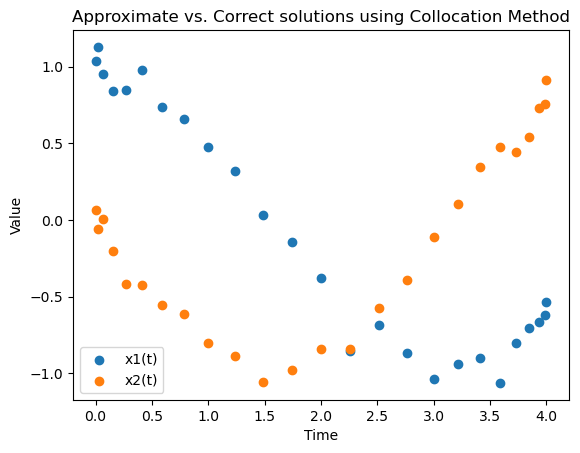

In [47]:
"""plt.scatter(t_grid, data_u, label='x1(t)')
plt.scatter(t_grid, data_v, label='x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.show()"""

### Pyomo -> ipopt 

In [52]:
jnp.linspace(0, T, N)

Array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
       1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
       2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
       3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ],      dtype=float64)

In [50]:
t_grid

Array([0.        , 0.01711035, 0.06814826, 0.15224075, 0.267949  ,
       0.41329336, 0.58578646, 0.78247714, 0.9999999 , 1.2346332 ,
       1.4823617 , 1.7389476 , 1.9999999 , 2.2610521 , 2.517638  ,
       2.7653668 , 3.        , 3.2175226 , 3.4142137 , 3.5867066 ,
       3.732051  , 3.847759  , 3.9318516 , 3.9828897 , 4.        ],      dtype=float32, weak_type=True)

In [51]:
jax.config.update("jax_enable_x64", True)

In [65]:
def chebyshev_nodes_second_kind(n, stop=1, start=-1):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (stop - start) * x + 0.5 * (start + stop)
    return np.sort(nodes)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      230
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       78

Total number of variables............................:       78
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       78
Total number

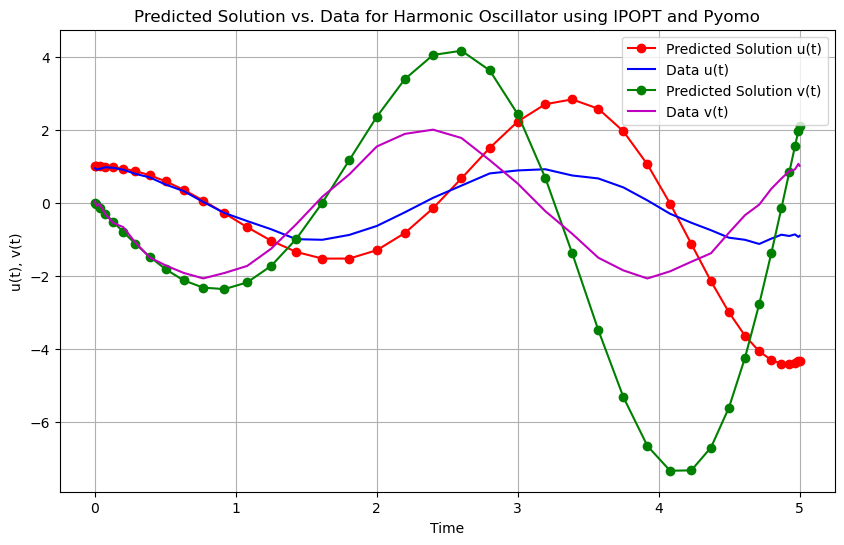

In [66]:
# Generate synthetic discrete data for the example
omega = 2.0  # Frequency of the harmonic oscillator
T = 5.0
N = 40
t_grid = np.linspace(0, T, N)
t_grid = chebyshev_nodes_second_kind(N, 0, T)

# True solution (for synthetic data generation purposes)
true_u = np.cos(omega * t_grid)
true_v = -omega * np.sin(omega * t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.05 * np.random.randn(N)
data_v = true_v + 0.05 * np.random.randn(N)

# Create a Pyomo model
model = ConcreteModel()

# Define the indexed set for the time grid
model.t_idx = RangeSet(0, N-1)

# Define the variables
model.u = Var(model.t_idx)
model.v = Var(model.t_idx)

# Initial conditions
model.u[0].fix(1.0)
model.v[0].fix(0.0)

# Define the ODE constraints
def _ode_u(m, i):
    if i == 0:
        return Constraint.Skip
    dt = t_grid[i] - t_grid[i-1]
    return (m.u[i] - m.u[i-1]) / dt == m.v[i-1]

def _ode_v(m, i):
    if i == 0:
        return Constraint.Skip
    dt = t_grid[i] - t_grid[i-1]
    return (m.v[i] - m.v[i-1]) / dt == -omega**2 * m.u[i-1]

model.ode_u = Constraint(model.t_idx, rule=_ode_u)
model.ode_v = Constraint(model.t_idx, rule=_ode_v)

# Define the objective function to minimize the difference from provided data
def _objective(m):
    return sum((m.u[i] - data_u[i])**2 + (m.v[i] - data_v[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=1)  # Minimizing the difference from the data points

# Solve the problem using IPOPT
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

# Extract the results
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

# Print the results
print("u(t):", u_solution)
print("v(t):", v_solution)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_grid, u_solution, 'ro-', label='Predicted Solution u(t)')
plt.plot(t_grid, data_u, 'b-', label='Data u(t)')
plt.plot(t_grid, v_solution, 'go-', label='Predicted Solution v(t)')
plt.plot(t_grid, data_v, 'm-', label='Data v(t)')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()
